<a href="https://colab.research.google.com/github/Piligrimich/ML/blob/main/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D1%8C%20%D0%B4%D0%BB%D1%8F%20CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import torchvision.datasets as dset
import matplotlib.pyplot as plt

from torchvision import transforms

from torch.utils.data.sampler import SubsetRandomSampler


In [2]:
transforms = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))    
])

data_train = dset.CIFAR10('./',train=True,download=True,transform=transforms)

data_test = dset.CIFAR10('./',train=False,download=True,transform=transforms)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [3]:
data_train.data.shape

(50000, 32, 32, 3)

In [4]:
all_classes = data_train.classes

In [5]:
batch_size = 64

train_size = data_train.data.shape[0]
validation_split = .2

split = int(np.floor(train_size*validation_split))
indices = list(range(train_size))

np.random.shuffle(indices)

train_indices,val_indices = indices[split:],indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train,batch_size=batch_size,sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train,batch_size=batch_size,sampler=val_sampler)


In [6]:
class LeNetModel(nn.Module):
  def __init__(self):
    super(LeNetModel,self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3,6,5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Conv2d(6,16,5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.BatchNorm2d(16)
    )
    self.classifier = nn.Sequential(
        nn.Linear(16*5*5,120),
        nn.BatchNorm1d(120),
        nn.Dropout(.5),
        nn.ReLU(),
        nn.Linear(120,84),
        nn.BatchNorm1d(84),
        nn.Dropout(.2),
        nn.ReLU(),
        nn.Linear(84,10)
    )
  def forward(self,x):
    x = self.features(x)
    x = torch.flatten(x,1) # или x = x.view(x.size(0),-1)
    x = self.classifier(x)
    return x

In [7]:
if torch.cuda.is_available:
  device = torch.device('cuda:0')
print(device)

cuda:0


In [8]:
model = LeNetModel()
model.to(device)

LeNetModel(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=84, bias=True)
    (5): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [9]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [10]:
def fit(model,train_loader,val_loader,loss,optimizer,num_epochs):
  
  for epoch in range(num_epochs):
    model.train()
    correct_samples = 0
    total_samples = 0
    loss_sum = 0
    for i_step, (x,y) in enumerate(train_loader):
      x,y = x.to(device),y.to(device)
      outputs = model(x)
      loss_value = loss(outputs,y)
      optimizer.zero_grad()
      loss_value.backward()
      optimizer.step()

      _,indices = torch.max(outputs,dim=1)
      correct_samples += torch.sum(indices == y)
      total_samples += y.shape[0]
      loss_sum += loss_value
    val_accuracy = validationAccuracy(model,val_loader)
    print("Epoch: %f  Accuracy %f  Val accuracy %f "%(epoch+1,(correct_samples/total_samples),val_accuracy))


def validationAccuracy(model,val_loader):
  model.eval()
  correct_samples = 0
  total_samples = 0
  for i_step,(x,y) in enumerate(val_loader):
    x,y = x.to(device),y.to(device)
    predicts = model(x)

    
    _, indices = torch.max(predicts,dim=1)
    correct_samples += torch.sum(indices == y)
    total_samples += y.shape[0]

  return correct_samples/total_samples

In [11]:
fit(model,train_loader,val_loader,loss,optimizer,20)

Epoch: 1.000000  Accuracy 0.389400  Val accuracy 0.476500 
Epoch: 2.000000  Accuracy 0.488725  Val accuracy 0.536700 
Epoch: 3.000000  Accuracy 0.525600  Val accuracy 0.578700 
Epoch: 4.000000  Accuracy 0.545475  Val accuracy 0.582200 
Epoch: 5.000000  Accuracy 0.566625  Val accuracy 0.567400 
Epoch: 6.000000  Accuracy 0.575525  Val accuracy 0.612700 
Epoch: 7.000000  Accuracy 0.585750  Val accuracy 0.610800 
Epoch: 8.000000  Accuracy 0.598050  Val accuracy 0.611200 
Epoch: 9.000000  Accuracy 0.599025  Val accuracy 0.627100 
Epoch: 10.000000  Accuracy 0.607900  Val accuracy 0.625900 
Epoch: 11.000000  Accuracy 0.612725  Val accuracy 0.631700 
Epoch: 12.000000  Accuracy 0.619425  Val accuracy 0.635000 
Epoch: 13.000000  Accuracy 0.625775  Val accuracy 0.632700 
Epoch: 14.000000  Accuracy 0.629075  Val accuracy 0.642000 
Epoch: 15.000000  Accuracy 0.635250  Val accuracy 0.643500 
Epoch: 16.000000  Accuracy 0.638175  Val accuracy 0.644100 
Epoch: 17.000000  Accuracy 0.639525  Val accuracy

In [12]:
batch_size = 64

data_size = data_test.data.shape[0]

indices = list(range(data_size))
np.random.shuffle(indices)

test_sampler = SubsetRandomSampler(indices)
test_loader = torch.utils.data.DataLoader(data_test,batch_size = batch_size,sampler = test_sampler)

In [13]:
def imagePrint(model, data, num):
  count = 0
  for x,y in data:
    count+=1
    x = x.to(device)
    pred = model(x)
    _,indices = torch.max(pred,dim=1)
    x = x.to('cpu')
    for i in range(2):
      print(f'сеть думает тут {all_classes[indices[i]]}')
      x[i] = x[i] /2+0.5
      img = x[i].permute(1,2,0).detach().numpy()
      plt.subplot(3,3,i+1)
      plt.imshow(img)
      plt.title(all_classes[y[i]])
    plt.show()
    if num == count:
      break

In [14]:
test_loader.dataset.data.shape

(10000, 32, 32, 3)

сеть думает тут horse
сеть думает тут truck


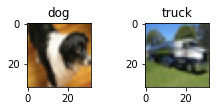

сеть думает тут horse
сеть думает тут dog


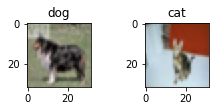

сеть думает тут truck
сеть думает тут ship


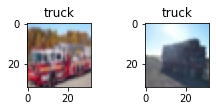

сеть думает тут automobile
сеть думает тут horse


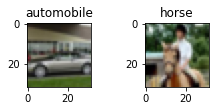

сеть думает тут airplane
сеть думает тут ship


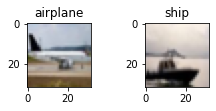

сеть думает тут cat
сеть думает тут deer


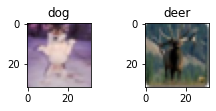

сеть думает тут deer
сеть думает тут dog


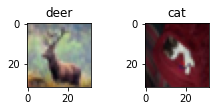

In [15]:
imagePrint(model,test_loader,7)

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusionMatrix(model,data):
  actual_data = []
  predicted_data = []
  for X,Y in data:
    X = X.to(device)
    #print(X.shape)
    pred = model(X)
    _,indices = torch.max(pred,dim=1)
    indices = indices.to('cpu')
    indices = indices.detach().numpy()
    Y = Y.detach().numpy()
    for i in range(len(X)):
      actual_data.append(Y[i])
      predicted_data.append(indices[i])

  cm = confusion_matrix(actual_data,predicted_data)
  cmd_obj = ConfusionMatrixDisplay(cm,display_labels=all_classes)
  cmd_obj.plot()


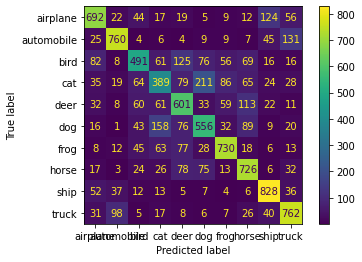

In [17]:
confusionMatrix(model,test_loader)